# Muscle Activity Analysis for Combined CPG+RFX Controller

## Introduction

In this jupyter notebook, we will study the muscle activities of the various muscles of the combined CPG and RFX model. We will then be able to compare the obtained results from the optimizations with experimental data from other research groups. 

In [1]:
# Imports
from wNMF import wNMF
import numpy as np
import matplotlib.pyplot as plt   # allows to plot charts
import pandas as pd              
import seaborn as sns    # python data visualization library based on matplotlib
import glob
import pickle
import os 
# To sort tests per test_id
from collections import OrderedDict

# To be allow to zoom in on the plots, uncomment the following lines
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

sns.set(style="darkgrid")

In [2]:
# Return a color map to assign colors to test_ids
def get_cmap(n, name='gist_rainbow'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

path_dir = "/home/efx/Desktop/osimrl_biorob/logs/simulation_data/Frequencies/Test_6_Frequencies"

# Loop to recursively look for files with .pkl extension, even in subfolders
pkl_files = {}
for root, dirs, files in os.walk(path_dir):
    folder_name_splitted = root.split(os.sep)[-1].split('_')
    if(len(folder_name_splitted) == 2 and folder_name_splitted[0] == "Best"):
        test_id = folder_name_splitted[1]
        pkl_files[test_id] = []
        for file in files:
            if file.split('_')[-1:][0] in ["values.pkl", "reflex.pkl", "muscle.pkl", "cpg.pkl"]:
                path = "{}{}{}".format(root, os.sep, file)
                pkl_files[test_id].append(path)
                print(pkl_files)
                
# Sort files per test_id asc
pkl_files = OrderedDict(sorted(pkl_files.items()))

# Color Map, assign a color to a test_id. The first test_id will be represented with the first color of the array aso...
possibleColors = get_cmap(len(pkl_files.keys()) + 1)
test_color = {}

# Open and load the files as dictionaries
# We store those dict in an bigger dict for futur reference, the filename will be the key
current_test = None
data = {}
count = 0
for test_id, files in pkl_files.items():
    if current_test != test_id:
        current_test = test_id
        data[current_test] = {}
        test_color[current_test] = possibleColors(count)
        count += 1
    for pkl in files:
        with open(pkl, 'rb') as f:
            data[current_test][pkl.split(os.sep)[-1].split('.')[-2].split('_')[-1]] = pickle.load(f)

##### Data structure #####
# values -> data['test_number']['values']
# reflex -> data['test_number']['reflex']
# muscle -> data['test_number']['muscle]
# cpg -> data['test_number']['cpg]

{'1.9': ['/home/efx/Desktop/osimrl_biorob/logs/simulation_data/Frequencies/Test_6_Frequencies/Best_1.9/Best_6_114_reflex.pkl']}
{'1.9': ['/home/efx/Desktop/osimrl_biorob/logs/simulation_data/Frequencies/Test_6_Frequencies/Best_1.9/Best_6_114_reflex.pkl', '/home/efx/Desktop/osimrl_biorob/logs/simulation_data/Frequencies/Test_6_Frequencies/Best_1.9/Best_6_114_muscle.pkl']}
{'1.9': ['/home/efx/Desktop/osimrl_biorob/logs/simulation_data/Frequencies/Test_6_Frequencies/Best_1.9/Best_6_114_reflex.pkl', '/home/efx/Desktop/osimrl_biorob/logs/simulation_data/Frequencies/Test_6_Frequencies/Best_1.9/Best_6_114_muscle.pkl', '/home/efx/Desktop/osimrl_biorob/logs/simulation_data/Frequencies/Test_6_Frequencies/Best_1.9/Best_6_114_values.pkl']}
{'1.9': ['/home/efx/Desktop/osimrl_biorob/logs/simulation_data/Frequencies/Test_6_Frequencies/Best_1.9/Best_6_114_reflex.pkl', '/home/efx/Desktop/osimrl_biorob/logs/simulation_data/Frequencies/Test_6_Frequencies/Best_1.9/Best_6_114_muscle.pkl', '/home/efx/Deskto

In [3]:
# Interpolation for all cycles
def getNormalizedData(data, start_cycles, end_cycles):
    Y = []
    N = 100
    for start_cycle, end_cycle in zip(start_cycles, end_cycles):
        yp = data[start_cycle:end_cycle]
        xp = range(len(yp))
        x = np.linspace(0,len(yp),N)
        y = np.interp(x, xp, yp)
        Y.append(y)
    Y = np.array(Y).transpose()
    return Y

# Interpolation for one cycle
def NormalizationOneCycle(data, start_cycle_left):
    N = 100
    yp = data[start_cycle_left[0]:start_cycle_left[1]-1]
    xp = range(len(yp))
    x = np.linspace(0,len(yp),N)
    y = np.interp(x, xp, yp)

# Plot with the standard deviation around the mean
def plotWithStd(normalized_data, title, xlabel, ylabel, legendlabel, color, fontsize=15):
    m = np.mean(normalized_data,1)
    s = np.std(normalized_data,1)
    LENGTH = normalized_data.shape[0]
    
    plt.plot(m, label=legendlabel, color=color)
    plt.suptitle(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.legend()
    plt.fill_between(np.linspace(0,LENGTH,LENGTH),m-s, m+s ,alpha=0.3, color=color)
    
# Plot the standard deviation around the mean, for the vertical line showing the end of the stance phase
def plotStdStance(normalized_data, ymin, ymax, color, linestyle, fontsize):
    m = np.mean(normalized_data)
    max = np.max(normalized_data)
    min = np.min(normalized_data)
    plt.axvline(min, alpha=0, color=color)
    plt.axvline(max, alpha=0, color=color)
    plt.axvline(m, color=color)
    plt.fill_between([min, max], [ymax, ymax], alpha=0.3, color=color)

# Plots with the standard deviation around the mean for real human data
def plotMeanStd(norm_mean, norm_min, norm_max, title, xlabel, ylabel, legendlabel, legendLoc, color):
    LENGTH = norm_mean.shape[0]
    plt.plot(norm_mean, label=legendlabel, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc = legendLoc)
    plt.fill_between(np.linspace(0, LENGTH, LENGTH), norm_min, norm_max ,alpha=0.3, color=color)
    
# Cast value val to int
def CastValInt(dataframe):
    dataframe['index'] = dataframe['index'].astype(int)

# Cast value val to float
def CastValFloat(dataframe):
    dataframe['norm_min'] = dataframe['norm_min'].astype(float)
    dataframe['norm_mean'] = dataframe['norm_mean'].astype(float)
    dataframe['norm_max'] = dataframe['norm_max'].astype(float)

## Real human data

We retrieve real human data that is used in Geyer's article from 2010. These data correspond to the joint angles, as well as the ground reaction forces, and this will allow us to compare the results retrieved from our simulations with the real human data. 
In order to do this, we first retrieve the data and format it to be close to the type of data that we have from the simulations. We cast the different values and format the table. 

In [4]:
real_data_dir = '/home/efx/Desktop/osimrl_biorob/RealHumanData'

HipFlexion = pd.read_excel('{}{}HipFlexion.ods'.format(real_data_dir, os.sep), engine='odf')
KneeFlexion = pd.read_excel('{}{}KneeFlexion.ods'.format(real_data_dir, os.sep), engine='odf')
AnkleFlexion = pd.read_excel('{}{}AnkleFlexion.ods'.format(real_data_dir, os.sep), engine='odf')
GroundReactionForces = pd.read_excel('{}{}GroundReactionForces.ods'.format(real_data_dir, os.sep), engine='odf')

# Data formatting
HipFlex = pd.DataFrame(HipFlexion, columns=['index', 'norm_min', 'norm_mean', 'norm_max'])
KneeFlex = pd.DataFrame(KneeFlexion, columns=['index', 'norm_min', 'norm_mean', 'norm_max'])
AnkleFlex = pd.DataFrame(AnkleFlexion, columns=['index', 'norm_min', 'norm_mean', 'norm_max'])
GRF = pd.DataFrame(GroundReactionForces, columns=['index', 'norm_min', 'norm_mean', 'norm_max'])

# Casting
CastValInt(HipFlex)
CastValFloat(HipFlex)
CastValInt(KneeFlex)
CastValFloat(KneeFlex)
CastValInt(AnkleFlex)
CastValFloat(AnkleFlex)
CastValInt(GRF)
CastValFloat(GRF)

GRF.head()

## HIP JOINT ANGLE formatting 
HipFlex_mean = HipFlex['norm_mean']
HipFlex_min = HipFlex['norm_min']
HipFlex_max = HipFlex['norm_max']

# KNEE JOINT ANGLE formatting
KneeFlex_mean = KneeFlex['norm_mean']
KneeFlex_min = KneeFlex['norm_min']
KneeFlex_max = KneeFlex['norm_max']

# ANKLE JOINT ANGLE formatting
AnkleFlex_mean = AnkleFlex['norm_mean']
AnkleFlex_min = AnkleFlex['norm_min']
AnkleFlex_max = AnkleFlex['norm_max']

# GROUND REACTION FORCES formatting
GRF_mean = GRF['norm_mean']
GRF_min = GRF['norm_min']
GRF_max = GRF['norm_max']

# Plots

## Plots of the ground reaction forces for one cycle

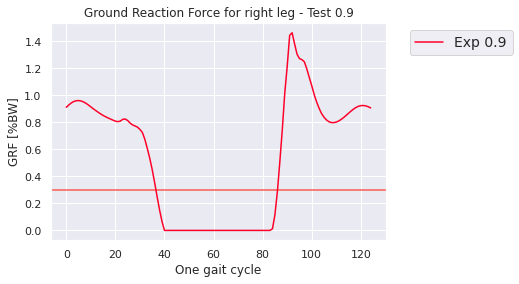

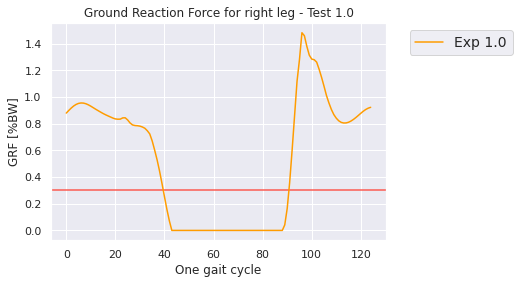

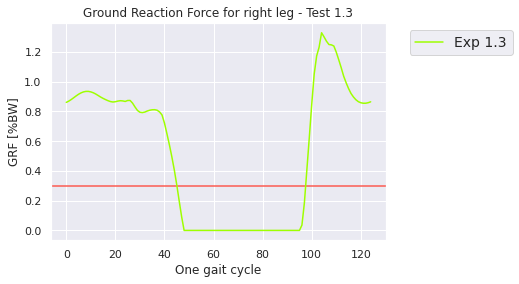

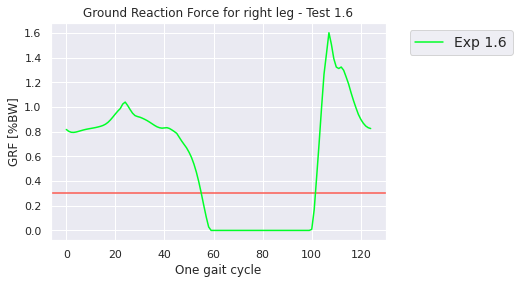

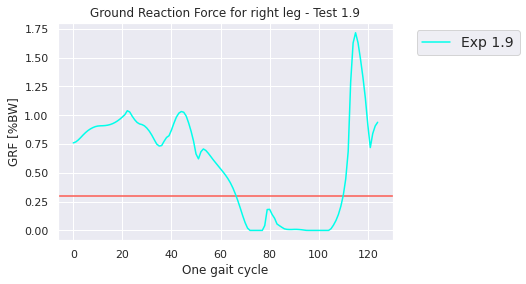

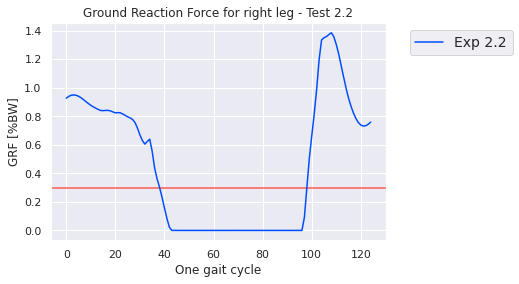

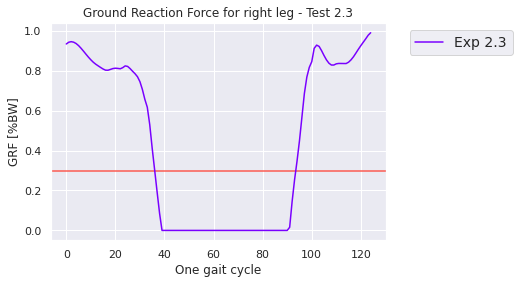

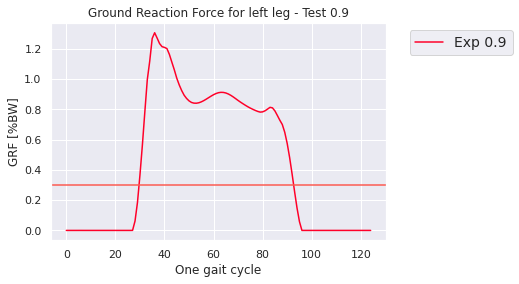

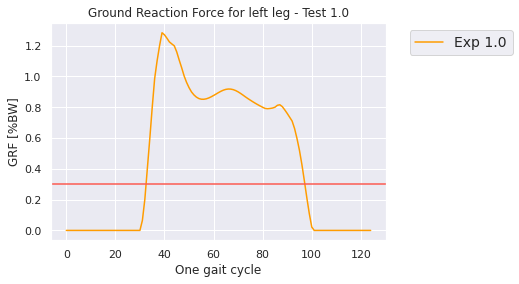

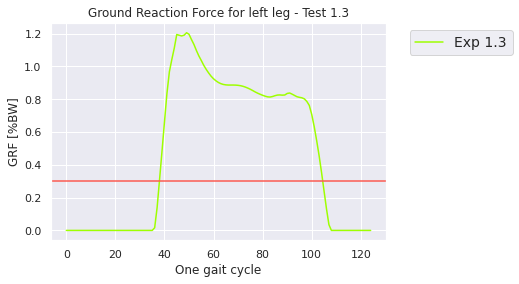

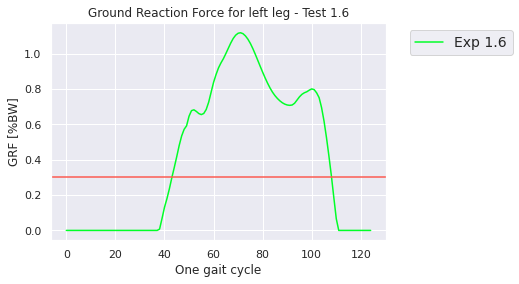

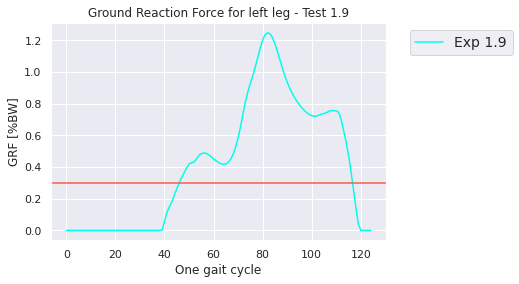

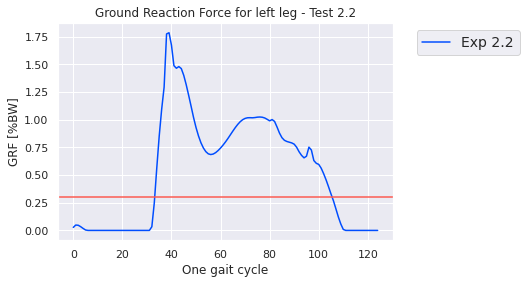

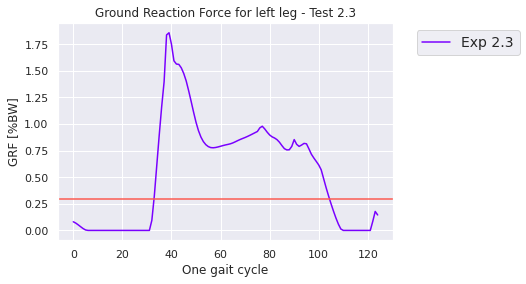

In [5]:
# Retrieval of the ground reaction forces along y-axis
grf_axis_y_rleg = {}
grf_axis_y_lleg = {}

for test_id, test in data.items():
    grf_axis_y_rleg[test_id] = [test['values'][i]["r_leg"]["ground_reaction_forces"][2] for i in range(len(test['values']))]
    grf_axis_y_lleg[test_id] = [test['values'][i]["l_leg"]["ground_reaction_forces"][2] for i in range(len(test['values']))]
    
# Plots of the GRF for the right and left leg separated
for test_id, grf in grf_axis_y_rleg.items(): 
    plt.axhline(y=0.3, color='xkcd:coral', linestyle='-')
    plt.plot(np.array(grf)[150:150+125,], color=test_color[test_id], label='Exp {}'.format(test_id))
    plt.title('Ground Reaction Force for right leg - Test {}'.format(test_id))
    plt.ylabel('GRF [%BW]')
    plt.xlabel('One gait cycle')
    plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left', prop={'size':14})
# To display all plot independently, please put the plt.show method back in the for loop as below
    plt.show()

for test_id, grf in grf_axis_y_lleg.items(): 
    plt.plot(np.array(grf)[150:150+125,], color=test_color[test_id], label='Exp {}'.format(test_id))
    plt.axhline(y=0.3, color='xkcd:coral', linestyle='-')
    plt.title('Ground Reaction Force for left leg - Test {}'.format(test_id))
    plt.ylabel('GRF [%BW]')
    plt.xlabel('One gait cycle')
    plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left', prop={'size':14})
    plt.show()

## Gait cycle characteristics

Here, we determine the start of each cycle during an entire simulation, for the left and the right leg independently, as well as the determination of the stance and swing phases. The data is normalized. 

In [6]:
# Separation in cycle + normalization of data + mean and std plot
GRF_Y_left = {}
GRF_Y_right = {}
for test_id, grf in grf_axis_y_lleg.items():
    GRF_Y_left[test_id] = np.array(grf)
for test_id, grf in grf_axis_y_rleg.items():
    GRF_Y_right[test_id] = np.array(grf)

START_CYCLE_l = {}
START_CYCLE_r = {}
for test_id, grf in GRF_Y_left.items():
    START_CYCLE_l[test_id] = np.where(np.diff(1.0*(grf > 0.2)) == 1)[0]
for test_id, grf in GRF_Y_right.items():
    START_CYCLE_r[test_id] = np.where(np.diff(1.0*(grf > 0.2)) == 1)[0]

dt = 0.01

# CYCLE DURATIONS FOR EACH SIMULATION
cycle_durations_left = {}
cycle_durations_right = {}
for test_id, start_cycles in START_CYCLE_l.items():
    cycle_durations_left[test_id] = (start_cycles[1:] - start_cycles[:-1])*dt   # in seconds
for test_id, start_cycles in START_CYCLE_r.items():
    cycle_durations_right[test_id] = (start_cycles[1:] - start_cycles[:-1])*dt  # in seconds

# Mean duration for each leg
mean_duration_left = {}
mean_duration_right = {}
for test_id, start_cycles in cycle_durations_left.items():
    mean_duration_left[test_id] = np.mean(cycle_durations_left[test_id])
for test_id, start_cycles in cycle_durations_right.items():
    mean_duration_right[test_id] = np.mean(cycle_durations_right[test_id])  
    
# Mean duration overall
mean_duration = {}
for test_id, start_cycles in mean_duration_left.items():
    for test_id, start_cycles in mean_duration_right.items():
        mean_duration[test_id] = (mean_duration_left[test_id] + mean_duration_right[test_id])/2
    
# STANCES AND SWINGS
LIFT_OFF_l = {}
LIFT_OFF_r = {}
for test_id, grf in GRF_Y_left.items():
    LIFT_OFF_l[test_id] = np.where(np.diff(1.0*(grf > 0.2)) == -1)[0]
for test_id, grf in GRF_Y_right.items():
    LIFT_OFF_r[test_id] = np.where(np.diff(1.0*(grf > 0.2)) == -1)[0]

# CONDITIONS
for test_id, start_cycles in START_CYCLE_l.items():
    if(start_cycles[0] > LIFT_OFF_l[test_id][0]):
        LIFT_OFF_l[test_id] = LIFT_OFF_l[test_id][1:]
for test_id, start_cycles in START_CYCLE_r.items():
    if(start_cycles[0] > LIFT_OFF_r[test_id][0]):
        LIFT_OFF_r[test_id] = LIFT_OFF_r[test_id][1:]
for test_id, lift_off in LIFT_OFF_l.items():
    lift_off = lift_off[len(START_CYCLE_l[test_id])-len(lift_off):]
for test_id, lift_off in LIFT_OFF_r.items():
    lift_off = lift_off[len(START_CYCLE_r[test_id])-len(lift_off):]    
for test_id, lift_off in LIFT_OFF_l.items():
    if (len(LIFT_OFF_l[test_id]) > len(cycle_durations_left[test_id])):
        LIFT_OFF_l[test_id] = LIFT_OFF_l[test_id][:-1]
for test_id, lift_off in LIFT_OFF_r.items():
    if (len(LIFT_OFF_r[test_id]) > len(cycle_durations_right[test_id])):
        LIFT_OFF_r[test_id] = LIFT_OFF_r[test_id][:-1]     

# STANCE/SWING durations - LEFT 
stance_durations_left = {}
swing_durations_left = {}
for test_id, lift_off in LIFT_OFF_l.items():
    stance_durations_left[test_id] = (lift_off - START_CYCLE_l[test_id][:len(lift_off)])*dt  # in seconds
    swing_durations_left[test_id] = (START_CYCLE_l[test_id][len(START_CYCLE_l[test_id]) - len(lift_off):] - lift_off)*dt  # in seconds

# STANCE/SWING durations - RIGHT
stance_durations_right = {}
swing_durations_right = {}
for test_id, lift_off in LIFT_OFF_r.items():
    stance_durations_right[test_id] = (lift_off - START_CYCLE_r[test_id][:len(lift_off)])*dt  # in seconds
    swing_durations_right[test_id] = (START_CYCLE_r[test_id][len(START_CYCLE_r[test_id]) - len(lift_off):] - lift_off)*dt  # in seconds

print(stance_durations_left)
print(stance_durations_right)

{'0.9': array([0.63, 0.64, 0.65, 0.64, 0.64, 0.64, 0.65, 0.64]), '1.0': array([0.64, 0.67, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66]), '1.3': array([0.66, 0.68, 0.69, 0.68, 0.67, 0.67, 0.67]), '1.6': array([0.67, 0.67, 0.67, 0.69, 0.67, 0.67, 0.67]), '1.9': array([0.64, 0.74, 0.72, 0.7 , 0.7 , 0.67, 0.71]), '2.2': array([0.65, 0.74, 0.76, 0.71, 0.87, 0.78, 0.89]), '2.3': array([0.65, 0.73, 0.68, 0.78, 0.71, 0.84, 0.88])}
{'0.9': array([0.67, 0.68, 0.65, 0.65, 0.65, 0.64, 0.64, 0.65]), '1.0': array([0.67, 0.69, 0.68, 0.68, 0.66, 0.67, 0.66, 0.66]), '1.3': array([0.66, 0.71, 0.7 , 0.7 , 0.71, 0.72, 0.73, 0.72]), '1.6': array([0.66, 0.79, 0.77, 0.86, 0.8 , 0.75, 0.72]), '1.9': array([0.68, 0.9 , 0.72, 0.85, 0.83, 0.8 , 0.87]), '2.2': array([0.68, 0.68, 0.74, 0.68, 0.7 , 0.74, 0.67]), '2.3': array([0.68, 0.65, 0.67, 0.72, 0.69, 0.71, 0.7 ])}


## Plots of the ground reaction forces over the entire gait cycle for both legs

Comparison with real human data


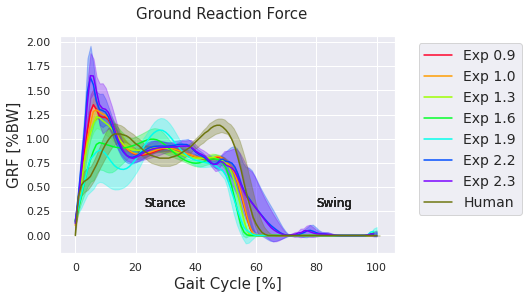

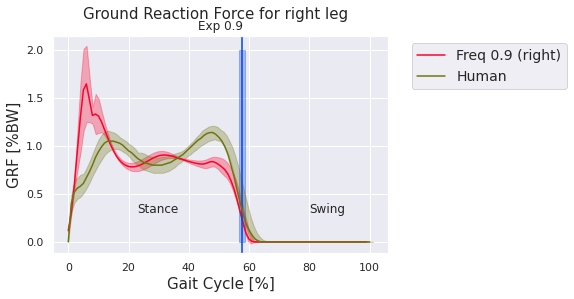

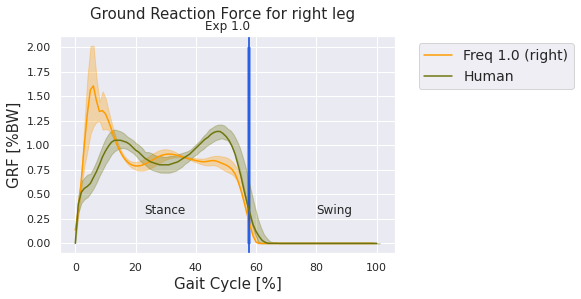

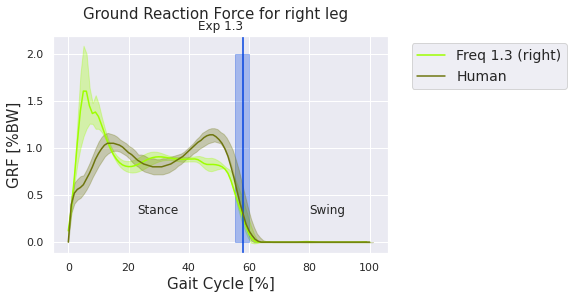

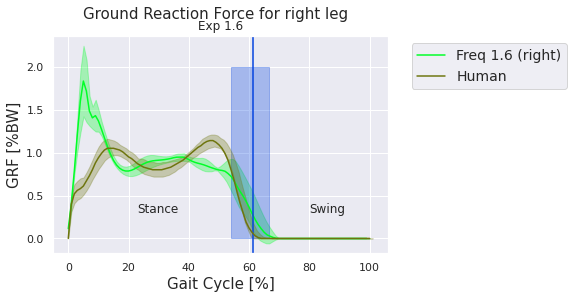

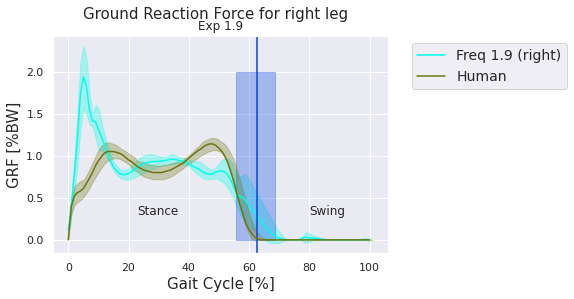

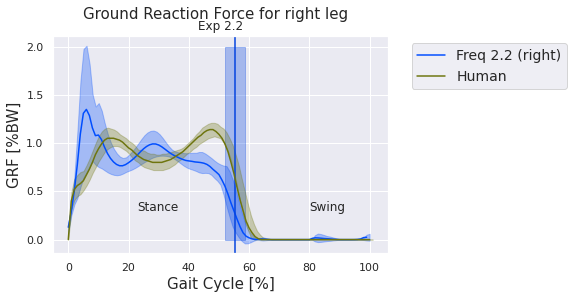

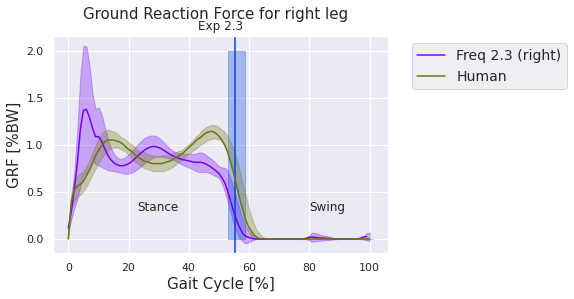

In [7]:
# Normalize data using pre-defined function
GRF_Y_norm_l = {}
GRF_Y_norm_r = {}
for test_id, grf in GRF_Y_left.items():
    GRF_Y_norm_l[test_id] = getNormalizedData(grf, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, grf in GRF_Y_right.items():
    GRF_Y_norm_r[test_id] = getNormalizedData(grf, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)

stance_norm_l = {}
stance_norm_r = {}
swing_norm_l = {}
swing_norm_r = {}

for test_id, duration in stance_durations_left.items():
    stance_norm_l[test_id] = (duration[:len(cycle_durations_left[test_id])]/cycle_durations_left[test_id])*100
for test_id, duration in stance_durations_right.items():
    stance_norm_r[test_id] = (duration[:len(cycle_durations_right[test_id])]/cycle_durations_right[test_id])*100
for test_id, duration in swing_durations_left.items():
    swing_norm_l[test_id] = (duration[:len(cycle_durations_left[test_id])]/cycle_durations_left[test_id])*100
for test_id, duration in swing_durations_right.items():
    swing_norm_r[test_id] = (duration[:len(cycle_durations_right[test_id])]/cycle_durations_right[test_id])*100

# Plots of the normalized ground reaction forces, compared to real human data for the right and left legs.
for test_id, grf in GRF_Y_norm_l.items():
    plotWithStd(grf, 'Ground Reaction Force', 'Gait Cycle [%]', 'GRF [%BW]', 'Exp {}'.format(test_id), test_color[test_id], 15)
    #plotStdStance(stance_norm_l[test_id], 0, 2, 'xkcd:blue', 'dashed', 17)
    plt.text(23, 0.3, 'Stance')
    plt.text(80, 0.3, 'Swing')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plotMeanStd(GRF_mean, GRF_min, GRF_max, '', 'Gait Cycle [%]', 'GRF [%BW]', 'Human', 'upper right', 'xkcd:olive')   
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.show()

for test_id, grf in GRF_Y_norm_r.items():
    plotWithStd(grf, 'Ground Reaction Force for right leg', 'Gait Cycle [%]', 'GRF [%BW]', 'Freq {} (right)'.format(test_id), test_color[test_id], 15)
    plotStdStance(stance_norm_r[test_id], 0, 2, 'xkcd:blue', 'dashed', 17)
    plotMeanStd(GRF_mean, GRF_min, GRF_max, 'Exp {}'.format(test_id), 'Gait Cycle [%]', 'GRF [%BW]', 'Human', 'upper right', 'xkcd:olive')
    plt.text(23, 0.3, 'Stance')
    plt.text(80, 0.3, 'Swing')
    plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
    plt.show()


## Plots of the muscle activities for both legs

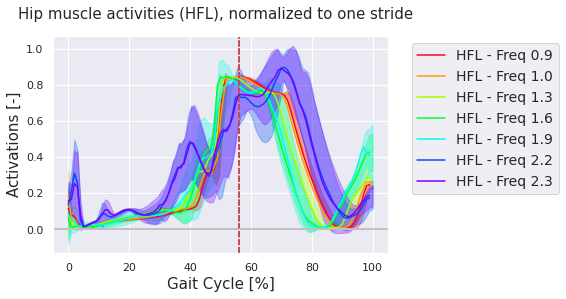

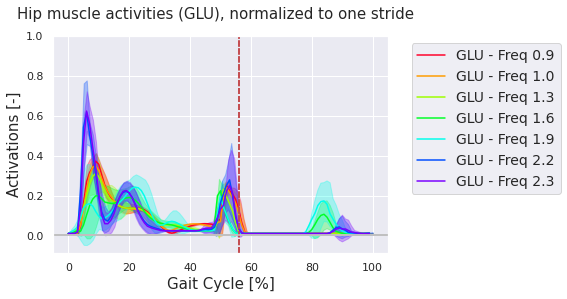

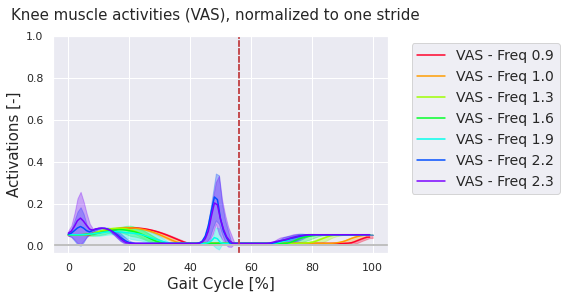

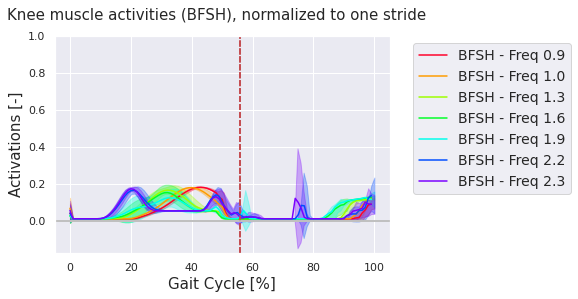

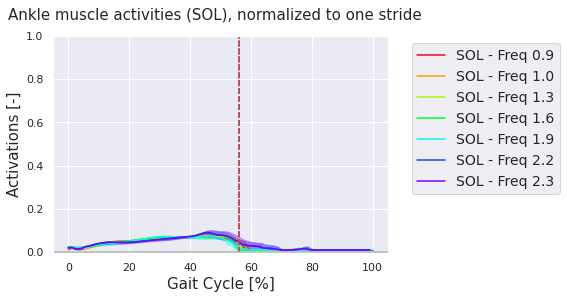

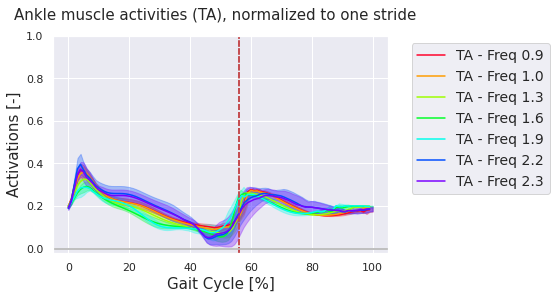

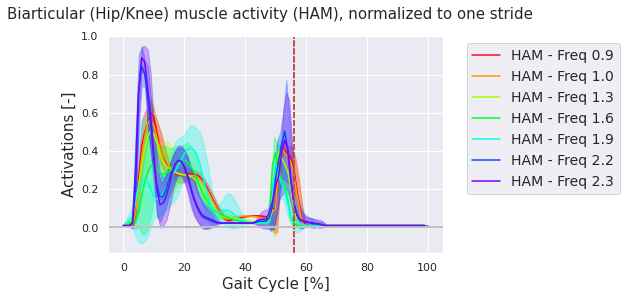

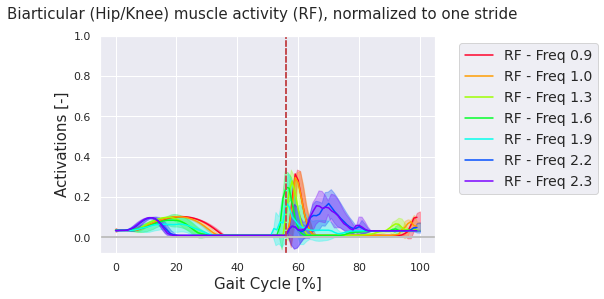

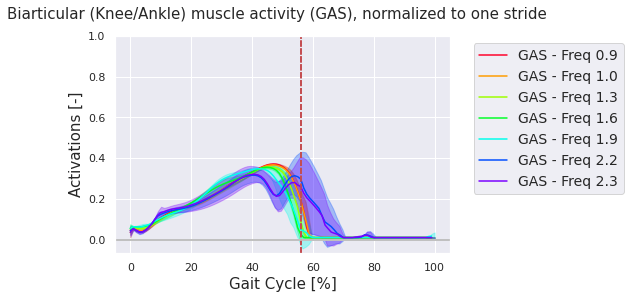

In [8]:
muscle_activations = {}
for test_id, test in data.items():
    muscle_activations[test_id] = [test['muscle'][i] for i in range(len(data[test_id]['muscle']))]

# Muscle activations from the muscles of the right leg
HFL_r  = {}
GLU_r  = {}
HAM_r  = {}
RF_r   = {}
VAS_r  = {}
BFSH_r = {}
GAS_r  = {}
SOL_r  = {}
TA_r   = {}

for test_id, muscle_activation in muscle_activations.items():
    HFL_r[test_id]  = np.clip([item[2] for item in muscle_activation], 0.01, 1)
    GLU_r[test_id]  = np.clip([item[3] for item in muscle_activation], 0.01, 1)
    HAM_r[test_id]  = np.clip([item[4] for item in muscle_activation], 0.01, 1)
    RF_r[test_id]   = np.clip([item[5] for item in muscle_activation], 0.01, 1)
    VAS_r[test_id]  = np.clip([item[6] for item in muscle_activation], 0.01, 1)
    BFSH_r[test_id] = np.clip([item[7] for item in muscle_activation], 0.01, 1)
    GAS_r[test_id]  = np.clip([item[8] for item in muscle_activation], 0.01, 1)
    SOL_r[test_id]  = np.clip([item[9] for item in muscle_activation], 0.01, 1)
    TA_r[test_id]  =  np.clip([item[10] for item in muscle_activation], 0.01, 1)
    
# Muscle activations from the muscles of the left leg
HFL_l  = {}
GLU_l  = {}
HAM_l  = {}
RF_l   = {}
VAS_l  = {}
BFSH_l = {}
GAS_l  = {}
SOL_l  = {}
TA_l   = {}

for test_id, muscle_activation in muscle_activations.items():
    HFL_l[test_id]  = np.clip([item[13] for item in muscle_activation], 0.01, 1)
    GLU_l[test_id]  = np.clip([item[14] for item in muscle_activation], 0.01, 1)
    HAM_l[test_id]  = np.clip([item[15] for item in muscle_activation], 0.01, 1)
    RF_l[test_id]   = np.clip([item[16] for item in muscle_activation], 0.01, 1)
    VAS_l[test_id]  = np.clip([item[17] for item in muscle_activation], 0.01, 1)
    BFSH_l[test_id] = np.clip([item[18] for item in muscle_activation], 0.01, 1)
    GAS_l[test_id]  = np.clip([item[19] for item in muscle_activation], 0.01, 1)
    SOL_l[test_id]  = np.clip([item[20] for item in muscle_activation], 0.01, 1)
    TA_l[test_id]   = np.clip([item[21] for item in muscle_activation], 0.01, 1)

# Normalized muscle activities involved in the hip only (HFL, GLU)
HFL_r_norm = {}
HFL_l_norm = {}
GLU_r_norm = {}
GLU_l_norm = {}

for test_id, hfl in HFL_r.items():
    HFL_r_norm[test_id] = getNormalizedData(hfl, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, hfl in HFL_l.items():
    HFL_l_norm[test_id] = getNormalizedData(hfl, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, glu in GLU_r.items():
    GLU_r_norm[test_id] = getNormalizedData(glu, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, glu in GLU_l.items():
    GLU_l_norm[test_id] = getNormalizedData(glu, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)   

# Plot of the hip muscle activities for both legs
for test_id in HFL_r_norm.keys():
    #plotWithStd(HFL_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'HFL_r', 'xkcd:red')
    plotWithStd(HFL_l_norm[test_id], 'Hip muscle activities (HFL), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'HFL - Freq {}'.format(test_id), test_color[test_id],15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart    
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.show()

# Plot of the hip muscle activities for both legs
for test_id in GLU_r_norm.keys():
    #plotWithStd(GLU_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'GLU_r', 'xkcd:orange')
    plotWithStd(GLU_l_norm[test_id], 'Hip muscle activities (GLU), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'GLU - Freq {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.show() 
    
# Normalized muscle activities involved in the knee only (VAS, BFSH)
VAS_r_norm = {}
VAS_l_norm = {}
BFSH_r_norm = {}
BFSH_l_norm = {}

for test_id, vas in VAS_r.items():
    VAS_r_norm[test_id] = getNormalizedData(vas, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, vas in VAS_l.items():
    VAS_l_norm[test_id] = getNormalizedData(vas, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, bfsh in BFSH_r.items():
    BFSH_r_norm[test_id] = getNormalizedData(bfsh, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, bfsh in BFSH_l.items():
    BFSH_l_norm[test_id] = getNormalizedData(bfsh, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1) 

# Plot of the knee muscle activities for both legs
for test_id in VAS_r_norm.keys():
    #plotWithStd(VAS_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'VAS_r', 'xkcd:red')
    plotWithStd(VAS_l_norm[test_id], 'Knee muscle activities (VAS), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'VAS - Freq {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()
    
# Plot of the knee muscle activities for both legs
for test_id in BFSH_r_norm.keys():
    #plotWithStd(BFSH_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'BFSH_r', 'xkcd:orange')
    plotWithStd(BFSH_l_norm[test_id], 'Knee muscle activities (BFSH), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'BFSH - Freq {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

# Normalized muscle activities involved in the ankle only (SOL, TA)
SOL_r_norm = {}
SOL_l_norm = {}
TA_r_norm = {}
TA_l_norm = {}

for test_id, sol in SOL_r.items():
    SOL_r_norm[test_id] = getNormalizedData(sol, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, sol in SOL_l.items():
    SOL_l_norm[test_id] = getNormalizedData(sol, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, ta in TA_r.items():
    TA_r_norm[test_id] = getNormalizedData(ta, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, ta in TA_l.items():
    TA_l_norm[test_id] = getNormalizedData(ta, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1) 

# Plot of the ankle muscle activities for both legs
for test_id in SOL_r_norm.keys():
    #plotWithStd(SOL_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'SOL_r', 'xkcd:red')
    plotWithStd(SOL_l_norm[test_id], 'Ankle muscle activities (SOL), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'SOL - Freq {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()
    
# Plot of the ankle muscle activities for both legs
for test_id in TA_r_norm.keys():
    #plotWithStd(TA_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'TA_r', 'xkcd:orange')
    plotWithStd(TA_l_norm[test_id], 'Ankle muscle activities (TA), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'TA - Freq {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

# Normalized biarticular muscle activities for the joint hip/knee (HAM, RF)
HAM_r_norm = {}
HAM_l_norm = {}
RF_r_norm = {}
RF_l_norm = {}
for test_id, ham in HAM_r.items():
    HAM_r_norm[test_id] = getNormalizedData(ham, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, ham in HAM_l.items():
    HAM_l_norm[test_id] = getNormalizedData(ham, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, rf in RF_r.items():
    RF_r_norm[test_id] = getNormalizedData(rf, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, rf in RF_l.items():
    RF_l_norm[test_id] = getNormalizedData(rf, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1) 

# Plot of the biarticular muscle activities from joint hip/knee
for test_id in HAM_r_norm.keys():
    #plotWithStd(HAM_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'HAM_r', 'xkcd:red')
    plotWithStd(HAM_l_norm[test_id], 'Biarticular (Hip/Knee) muscle activity (HAM), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'HAM - Freq {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

# Plot of the biarticular muscle activities from joint hip/knee
for test_id in RF_r_norm.keys():
    #plotWithStd(RF_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'RF_r', 'xkcd:orange')
    plotWithStd(RF_l_norm[test_id], 'Biarticular (Hip/Knee) muscle activity (RF), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'RF - Freq {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

# Normalized biarticular muscle activity for the joint knee/ankle (GAS)
GAS_r_norm = {}
GAS_l_norm = {}
for test_id, gas in GAS_r.items():
    GAS_r_norm[test_id] = getNormalizedData(gas, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, gas in GAS_l.items():
    GAS_l_norm[test_id] = getNormalizedData(gas, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)

# Plot of the biarticular muscle activity from the joint knee/ankle
for test_id in GAS_r_norm.keys():
    #plotWithStd(GAS_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'GAS_r', 'xkcd:orange')
    plotWithStd(GAS_l_norm[test_id], 'Biarticular (Knee/Ankle) muscle activity (GAS), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'GAS - Freq {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

## Plots of the joint angles (hip, knee, ankle) with respect to real human data


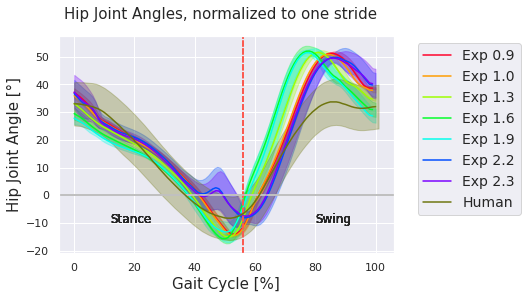

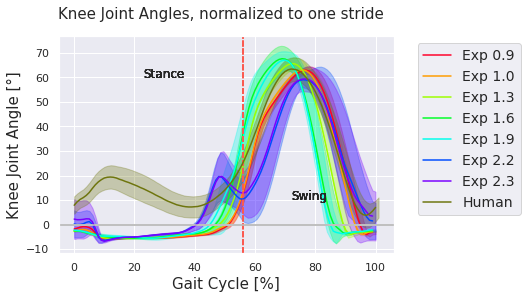

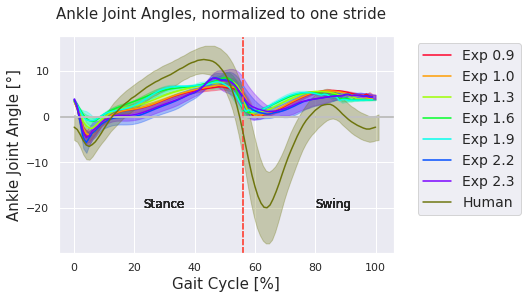

In [9]:
## HIP JOINT ANGLES
# Retrieve the output from the optimizations
hip_angle_rleg = {}
hip_angle_lleg = {}
for test_id, test in data.items():
    hip_angle_rleg[test_id] = [test['values'][i]["r_leg"]["joint"]["hip"] * 180/np.pi for i in range(len(test['values']))]
    hip_angle_lleg[test_id] = [test['values'][i]["l_leg"]["joint"]["hip"] * 180/np.pi for i in range(len(test['values']))]

# Normalize data
hip_norm_left = {}
hip_norm_right = {}
for test_id, hip_angle in hip_angle_lleg.items():
    hip_norm_left[test_id] = getNormalizedData(hip_angle, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, hip_angle in hip_angle_rleg.items():
    hip_norm_right[test_id] = getNormalizedData(hip_angle, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)

# Multiply the norms by -1 to follow the conventions of various articles and plot against real human data
for test_id in hip_norm_left.keys():
    plotWithStd(-1*hip_norm_left[test_id], 'Hip Joint Angles, normalized to one stride', 'Gait Cycle [%]', 'Angles [°]', 'Exp {}'.format(test_id), test_color[test_id], 15)
    #plotWithStd(-1*hip_norm_right[test_id], 'Hip angles for both legs', 'Gait Cycle [%]', 'Angles [°]', 'Right (model)', 'xkcd:blue')
    plt.axvline(56, 0, 2, color='xkcd:coral', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plt.text(12, -10, 'Stance')
    plt.text(80, -10, 'Swing')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plotMeanStd(HipFlex_mean, HipFlex_min, HipFlex_max, '', 'Gait Cycle [%]', 'Hip Joint Angle [°]', 'Human', 'lower right', 'xkcd:olive')
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.show()

# KNEE JOINT ANGLES
# Retrieve the output from the optimizations
knee_angle_rleg = {}
knee_angle_lleg = {}
for test_id, test in data.items():
    knee_angle_rleg[test_id] = [(test['values'][i]["r_leg"]["joint"]["knee"])* 180/np.pi for i in range(len(test['values']))]
    knee_angle_lleg[test_id] = [(test['values'][i]["l_leg"]["joint"]["knee"])* 180/np.pi for i in range(len(test['values']))]

# Normalize data
knee_norm_left = {}
knee_norm_right = {}
for test_id, knee in knee_angle_lleg.items():
    knee_norm_left[test_id] = getNormalizedData(knee, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, knee in knee_angle_rleg.items():
    knee_norm_right[test_id] = getNormalizedData(knee, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)


# Multiply the norms by -1 to follow convention, and plot against real human data
for test_id in knee_norm_left.keys():
    plotWithStd(-1*knee_norm_left[test_id], 'Knee Joint Angles, normalized to one stride', 'Gait Cycle [%]', 'Angles [°]', 'Exp {}'.format(test_id), test_color[test_id], 15)
    #plotWithStd(-1*knee_norm_right[test_id], 'Knee angles for both legs', 'Gait Cycle [%]', 'Angles [°]', 'Right (model)', 'xkcd:blue')
    plt.axvline(56, 0, 2, color='xkcd:coral', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plt.text(23, 60, 'Stance')
    plt.text(72, 10, 'Swing')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plotMeanStd(KneeFlex_mean, KneeFlex_min, KneeFlex_max, '', 'Gait Cycle [%]', 'Knee Joint Angle [°]', 'Human', 'upper left', 'xkcd:olive')
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.show()

# ANKLE JOINT ANGLES
# Retrieve the output from the optimizations
ankle_angle_rleg = {}
ankle_angle_lleg = {}
for test_id, test in data.items():
    ankle_angle_rleg[test_id] = [(test['values'][i]["r_leg"]["joint"]["ankle"])* 180/np.pi for i in range(len(test['values']))]
    ankle_angle_lleg[test_id] = [(test['values'][i]["l_leg"]["joint"]["ankle"])* 180/np.pi for i in range(len(test['values']))]

# Normalize data
ankle_norm_left = {}
ankle_norm_right = {}
for test_id, ankle in ankle_angle_lleg.items():
    ankle_norm_left[test_id] = getNormalizedData(ankle, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, ankle in ankle_angle_rleg.items():
    ankle_norm_right[test_id] = getNormalizedData(ankle, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)

# Multiply the norms by -1 to follow convention, and plot against real human data
for test_id in ankle_norm_left.keys():
    plotWithStd(-1*ankle_norm_left[test_id], 'Ankle Joint Angles, normalized to one stride', 'Gait Cycle [%]', 'Angles [°]', 'Exp {}'.format(test_id), test_color[test_id], 15)
    #plotWithStd(-1*ankle_norm_right[test_id], 'Ankle angles for both legs', 'Gait Cycle [%]', 'Angles [°]', 'Right (model)', 'xkcd:blue')
    plt.axvline(56, 0, 2, color='xkcd:coral', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plt.text(23, -20, 'Stance')
    plt.text(80, -20, 'Swing')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plotMeanStd(AnkleFlex_mean+20, AnkleFlex_min+20, AnkleFlex_max+20, '', 'Gait Cycle [%]', 'Ankle Joint Angle [°]', 'Human', 'lower left', 'xkcd:olive')
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.show()

## Velocity retrieval and Determination of the step length and step duration for each experiment performed with this controller


In [10]:
# Retrieve velocity from the optimizations.
velocity = {}
for test_id, test in data.items():
        velocity[test_id] = [test['values'][i]["pelvis"]["vel"][0] for i in range(len(test['values']))]

velocity_body = {}
# Getting rid of the trailing non-accomplished steps
for test_id in START_CYCLE_l.keys():
    start_time_ms = START_CYCLE_l[test_id][0]
    velocity_body[test_id] = velocity[test_id][start_time_ms:]
    START_CYCLE_l[test_id] = np.array([i - start_time_ms for i in START_CYCLE_l[test_id]])

for test_id in START_CYCLE_r.keys():
    start_time_ms = START_CYCLE_r[test_id][0]
    START_CYCLE_r[test_id] = np.array([i - start_time_ms for i in START_CYCLE_r[test_id]])

general_mean_duration = {}    
general_duration = {}
    
for test_id, val in START_CYCLE_l.items():
    print()
    print("TEST: ", test_id)
    temp_steps_duration = []
    index = 1
    previousval = 0
    for v in val[1:]:
            print("STEP", index, " : ", (v - previousval)/100)
            temp_steps_duration.append(v - previousval)
            previousval = v
            index += 1
    general_mean_duration[test_id] = np.mean(temp_steps_duration)/100    
    general_duration[test_id] = np.sum(temp_steps_duration)/100
    print("MEAN STEP DURATION ", np.mean(temp_steps_duration)/100)
print()
print()
general_mean_length = {}
general_mean_velocity = {}
velocity_per_steps = {}
for test_id in velocity.keys():
    previousval = 0
    velocity_per_steps[test_id] = []
    for cycle in START_CYCLE_l[test_id]:
        if(cycle != 0):
            velocity_per_steps[test_id].append(np.mean(velocity_body[test_id][previousval:cycle]))
        previousval = cycle
    general_mean_velocity[test_id] = np.mean(velocity_per_steps[test_id])
    general_mean_length[test_id] = (general_mean_velocity[test_id] * general_duration[test_id]) + 0.6
# + 0.6 to take into account the fact that the simulation ends during a step. 
    
print("MEAN DURATION (s)", general_mean_duration)
print("VELOCITY (m/s)", general_mean_velocity)
print("DISTANCE (m)", general_mean_length)
print()
print()
for test_id in START_CYCLE_l.keys():
    print()
    print("TEST", test_id)
    print("DISTANCE PER STEP (m)", general_mean_length[test_id] / (len(START_CYCLE_l[test_id]) + len(START_CYCLE_r[test_id])))
    print("DURATION PER STEP (ms)", general_mean_duration[test_id])


TEST:  0.9
STEP 1  :  1.14
STEP 2  :  1.13
STEP 3  :  1.14
STEP 4  :  1.13
STEP 5  :  1.13
STEP 6  :  1.12
STEP 7  :  1.14
STEP 8  :  1.13
MEAN STEP DURATION  1.1325

TEST:  1.0
STEP 1  :  1.16
STEP 2  :  1.18
STEP 3  :  1.18
STEP 4  :  1.16
STEP 5  :  1.16
STEP 6  :  1.16
STEP 7  :  1.15
STEP 8  :  1.15
MEAN STEP DURATION  1.1625

TEST:  1.3
STEP 1  :  1.21
STEP 2  :  1.21
STEP 3  :  1.23
STEP 4  :  1.22
STEP 5  :  1.22
STEP 6  :  1.23
STEP 7  :  1.21
MEAN STEP DURATION  1.2185714285714286

TEST:  1.6
STEP 1  :  1.25
STEP 2  :  1.25
STEP 3  :  1.28
STEP 4  :  1.29
STEP 5  :  1.24
STEP 6  :  1.22
STEP 7  :  1.22
MEAN STEP DURATION  1.25

TEST:  1.9
STEP 1  :  1.27
STEP 2  :  1.28
STEP 3  :  1.35
STEP 4  :  1.29
STEP 5  :  1.28
STEP 6  :  1.28
STEP 7  :  1.31
MEAN STEP DURATION  1.2942857142857143

TEST:  2.2
STEP 1  :  1.17
STEP 2  :  1.32
STEP 3  :  1.22
STEP 4  :  1.28
STEP 5  :  1.33
STEP 6  :  1.27
STEP 7  :  1.32
MEAN STEP DURATION  1.272857142857143

TEST:  2.3
STEP 1  :  1.17
S

## Plots of the CPG contribution to the overall muscle activities


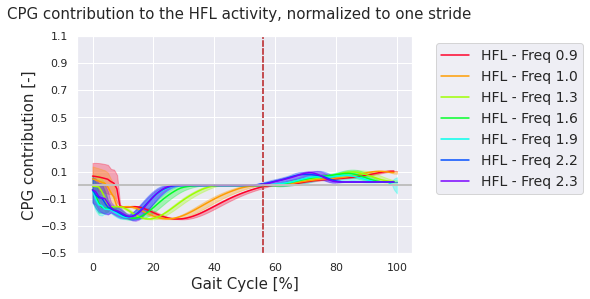

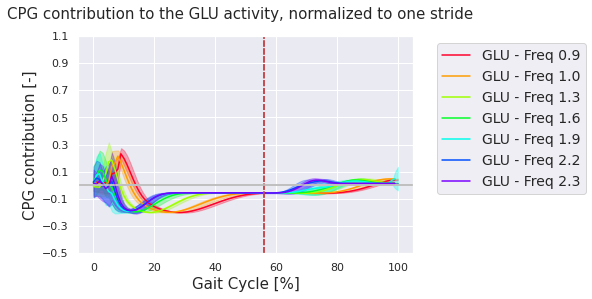

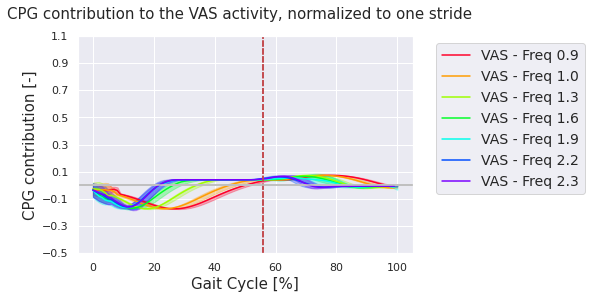

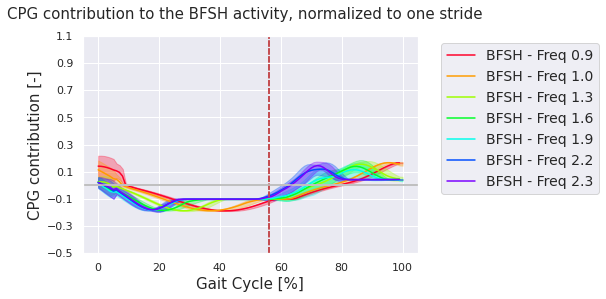

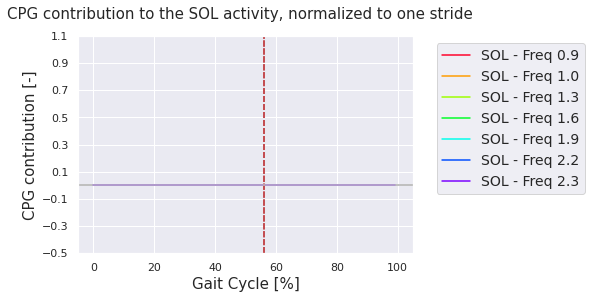

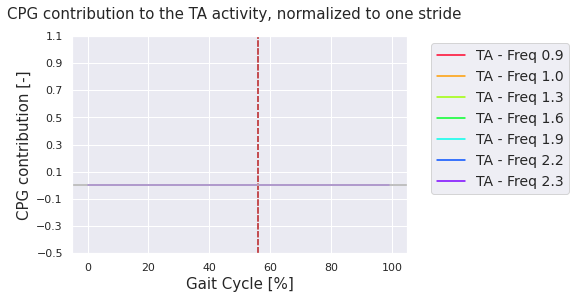

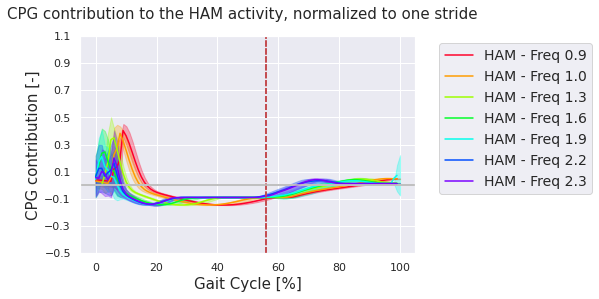

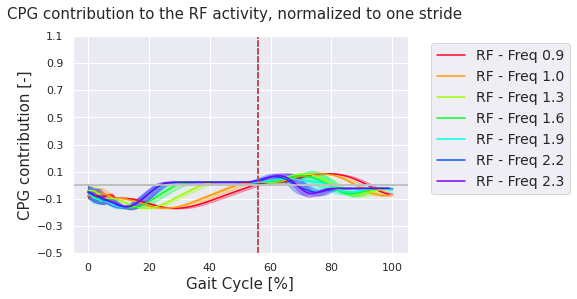

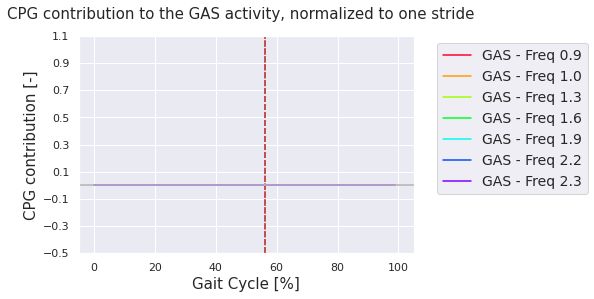

In [11]:
# CPG Contribution
cpg_contribution = {}
for test_id, test in data.items():
    cpg_contribution[test_id] = [test['cpg'][i] for i in range(len(data[test_id]['cpg']))]

# CPG contribution to the muscles of the right leg
HFL_r_cpg  = {}
GLU_r_cpg  = {}
HAM_r_cpg  = {}
RF_r_cpg   = {}
VAS_r_cpg  = {}
BFSH_r_cpg = {}
GAS_r_cpg  = {}
SOL_r_cpg  = {}
TA_r_cpg   = {}

for test_id, cpg_activation in cpg_contribution.items():
    HFL_r_cpg[test_id]  = [item[2] for item in cpg_activation]
    GLU_r_cpg[test_id]  = [item[3] for item in cpg_activation]
    HAM_r_cpg[test_id]  = [item[4] for item in cpg_activation]
    RF_r_cpg[test_id]   = [item[5] for item in cpg_activation]
    VAS_r_cpg[test_id]  = [item[6] for item in cpg_activation]
    BFSH_r_cpg[test_id] = [item[7] for item in cpg_activation]
    GAS_r_cpg[test_id]  = [item[8] for item in cpg_activation]
    SOL_r_cpg[test_id]  = [item[9] for item in cpg_activation]
    TA_r_cpg[test_id]  =  [item[10] for item in cpg_activation]
    
# CPG contribution to the muscles of the left leg
HFL_l_cpg  = {}
GLU_l_cpg  = {}
HAM_l_cpg  = {}
RF_l_cpg   = {}
VAS_l_cpg  = {}
BFSH_l_cpg = {}
GAS_l_cpg  = {}
SOL_l_cpg  = {}
TA_l_cpg   = {}

for test_id, cpg_activation in cpg_contribution.items():
    HFL_l_cpg[test_id]  = [item[13] for item in cpg_activation]
    GLU_l_cpg[test_id]  = [item[14] for item in cpg_activation]
    HAM_l_cpg[test_id]  = [item[15] for item in cpg_activation]
    RF_l_cpg[test_id]   = [item[16] for item in cpg_activation]
    VAS_l_cpg[test_id]  = [item[17] for item in cpg_activation]
    BFSH_l_cpg[test_id] = [item[18] for item in cpg_activation]
    GAS_l_cpg[test_id]  = [item[19] for item in cpg_activation]
    SOL_l_cpg[test_id]  = [item[20] for item in cpg_activation]
    TA_l_cpg[test_id]   = [item[21] for item in cpg_activation]

# Normalized CPG contribution to the muscle activities involved in the hip only (HFL, GLU)
HFL_r_norm_cpg = {}
HFL_l_norm_cpg = {}
GLU_r_norm_cpg = {}
GLU_l_norm_cpg = {}

for test_id, hfl in HFL_r_cpg.items():
    HFL_r_norm_cpg[test_id] = getNormalizedData(hfl, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, hfl in HFL_l_cpg.items():
    HFL_l_norm_cpg[test_id] = getNormalizedData(hfl, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, glu in GLU_r_cpg.items():
    GLU_r_norm_cpg[test_id] = getNormalizedData(glu, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, glu in GLU_l_cpg.items():
    GLU_l_norm_cpg[test_id] = getNormalizedData(glu, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)   

# Plot of the CPG contribution to the hip muscle activities for both legs
for test_id in HFL_r_norm_cpg.keys():
    #plotWithStd(HFL_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'HFL_r', 'xkcd:red')
    plotWithStd(HFL_l_norm_cpg[test_id], 'CPG contribution to the HFL activity, normalized to one stride', 'Gait Cycle [%]', 'CPG contribution [-]', 'HFL - Freq {}'.format(test_id), test_color[test_id],15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart    
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(-0.5, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

# Plot of the hip muscle activities for both legs
for test_id in GLU_r_norm_cpg.keys():
    #plotWithStd(GLU_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'GLU_r', 'xkcd:orange')
    plotWithStd(GLU_l_norm_cpg[test_id], 'CPG contribution to the GLU activity, normalized to one stride', 'Gait Cycle [%]', 'CPG contribution [-]', 'GLU - Freq {}'.format(test_id), test_color[test_id],15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(-0.5, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show() 

# Normalized CPG contribution to the muscle activities involved in the knee only (VAS, BFSH)
VAS_r_norm_cpg = {}
VAS_l_norm_cpg = {}
BFSH_r_norm_cpg = {}
BFSH_l_norm_cpg = {}

for test_id, vas in VAS_r_cpg.items():
    VAS_r_norm_cpg[test_id] = getNormalizedData(vas, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, vas in VAS_l_cpg.items():
    VAS_l_norm_cpg[test_id] = getNormalizedData(vas, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, bfsh in BFSH_r_cpg.items():
    BFSH_r_norm_cpg[test_id] = getNormalizedData(bfsh, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, bfsh in BFSH_l_cpg.items():
    BFSH_l_norm_cpg[test_id] = getNormalizedData(bfsh, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1) 

# Plot of the CPG contribution to the knee muscle activities for both legs
for test_id in VAS_r_norm_cpg.keys():
    #plotWithStd(VAS_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'VAS_r', 'xkcd:red')
    plotWithStd(VAS_l_norm_cpg[test_id], 'CPG contribution to the VAS activity, normalized to one stride', 'Gait Cycle [%]', 'CPG contribution [-]', 'VAS - Freq {}'.format(test_id), test_color[test_id],15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(-0.5, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()
    
# Plot of the CPG contribution to the knee muscle activities for both legs
for test_id in BFSH_r_norm_cpg.keys():
    #plotWithStd(BFSH_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'BFSH_r', 'xkcd:orange')
    plotWithStd(BFSH_l_norm_cpg[test_id], 'CPG contribution to the BFSH activity, normalized to one stride', 'Gait Cycle [%]', 'CPG contribution [-]', 'BFSH - Freq {}'.format(test_id), test_color[test_id],15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(-0.5, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

# Normalized CPG contribution to the muscle activities involved in the ankle only (SOL, TA)
SOL_r_norm_cpg = {}
SOL_l_norm_cpg = {}
TA_r_norm_cpg = {}
TA_l_norm_cpg = {}

for test_id, sol in SOL_r_cpg.items():
    SOL_r_norm_cpg[test_id] = getNormalizedData(sol, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, sol in SOL_l_cpg.items():
    SOL_l_norm_cpg[test_id] = getNormalizedData(sol, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, ta in TA_r_cpg.items():
    TA_r_norm_cpg[test_id] = getNormalizedData(ta, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, ta in TA_l_cpg.items():
    TA_l_norm_cpg[test_id] = getNormalizedData(ta, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1) 

# Plot of the CPG contribution to the SOL muscle
for test_id in SOL_r_norm_cpg.keys():
    #plotWithStd(SOL_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'SOL_r', 'xkcd:red')
    plotWithStd(SOL_l_norm_cpg[test_id], 'CPG contribution to the SOL activity, normalized to one stride', 'Gait Cycle [%]', 'CPG contribution [-]', 'SOL - Freq {}'.format(test_id), test_color[test_id],15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(-0.5, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()
    
# Plot of the CPG contribution to TA muscle
for test_id in TA_r_norm_cpg.keys():
    #plotWithStd(TA_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'TA_r', 'xkcd:orange')
    plotWithStd(TA_l_norm_cpg[test_id], 'CPG contribution to the TA activity, normalized to one stride', 'Gait Cycle [%]', 'CPG contribution [-]', 'TA - Freq {}'.format(test_id), test_color[test_id],15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(-0.5, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

# Normalized CPG contribution to biarticular muscle activities for the joint hip/knee (HAM, RF)
HAM_r_norm_cpg = {}
HAM_l_norm_cpg = {}
RF_r_norm_cpg = {}
RF_l_norm_cpg = {}
for test_id, ham in HAM_r_cpg.items():
    HAM_r_norm_cpg[test_id] = getNormalizedData(ham, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, ham in HAM_l_cpg.items():
    HAM_l_norm_cpg[test_id] = getNormalizedData(ham, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, rf in RF_r_cpg.items():
    RF_r_norm_cpg[test_id] = getNormalizedData(rf, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, rf in RF_l_cpg.items():
    RF_l_norm_cpg[test_id] = getNormalizedData(rf, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1) 

# Plot of the CPG contribution biarticular muscle activities from joint hip/knee
for test_id in HAM_r_norm_cpg.keys():
    #plotWithStd(HAM_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'HAM_r', 'xkcd:red')
    plotWithStd(HAM_l_norm_cpg[test_id], 'CPG contribution to the HAM activity, normalized to one stride', 'Gait Cycle [%]', 'CPG contribution [-]', 'HAM - Freq {}'.format(test_id), test_color[test_id],15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(-0.5, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

# Plot of the CPG contribution biarticular muscle activities from joint hip/knee
for test_id in RF_r_norm_cpg.keys():
    #plotWithStd(RF_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'RF_r', 'xkcd:orange')
    plotWithStd(RF_l_norm_cpg[test_id], 'CPG contribution to the RF activity, normalized to one stride', 'Gait Cycle [%]', 'CPG contribution [-]', 'RF - Freq {}'.format(test_id), test_color[test_id],15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(-0.5, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

# Normalized CPG contribution to the biarticular muscle activity for the joint knee/ankle (GAS)
GAS_r_norm_cpg = {}
GAS_l_norm_cpg = {}
for test_id, gas in GAS_r_cpg.items():
    GAS_r_norm_cpg[test_id] = getNormalizedData(gas, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, gas in GAS_l_cpg.items():
    GAS_l_norm_cpg[test_id] = getNormalizedData(gas, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)

# Plot of the CPG contribution to the biarticular muscle activity from the joint knee/ankle
for test_id in GAS_r_norm_cpg.keys():
    #plotWithStd(GAS_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'GAS_r', 'xkcd:orange')
    plotWithStd(GAS_l_norm_cpg[test_id], 'CPG contribution to the GAS activity, normalized to one stride', 'Gait Cycle [%]', 'CPG contribution [-]', 'GAS - Freq {}'.format(test_id), test_color[test_id],15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(-0.5, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()